# Libraries

The libraries listed below will be used in the execution of this project. Assisting us from data processing to prediction. 

In [5]:
import numpy as np
import pandas as pd
import nltk
import re
import os
from unidecode import unidecode
import contractions
import swifter

# librosa to process audio files
import librosa as lb
import soundfile as sf
from scipy import signal

# play audio file
from IPython.display import Audio

# import libs for lemmitization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# download lemmitization data|
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# import viz libs
import matplotlib.pyplot as plt
import seaborn as sns

# import the dataframe split from sklearn
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/giliardyminicucci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/giliardyminicucci/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/giliardyminicucci/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import the IEMOCAP and MELD dataframes

From the process previously written to extract the information are going to load the dataframe which contains the emotions, transcriptions and other information that will be used in this project

In [6]:
# import both datasets
iemocap_df = pd.read_csv('../Data/IEMOCAP/IEMOCAP_DF.csv')
meld_df = pd.read_csv('../Data/MELD/MELD_DF.csv')

In [7]:
# only keep the columns we need for the project 
iemocap_df = iemocap_df[['dataset', 'filename', 'filepath', 'transcription', 'emotion_label']]
meld_df = meld_df[['dataset','filename', 'filepath', 'Utterance', 'Emotion']]

# rename meld uterance column to transcription and emotion to emotion_label
meld_col_name = {'Utterance': 'transcription', 'Emotion': 'emotion_label'}
meld_df = meld_df.rename(columns=meld_col_name)

# concat the two dataframes
df = pd.concat([iemocap_df, meld_df], ignore_index=True)

In [8]:
df

,dataset,filename,filepath,transcription,emotion_label
0,IEMOCAP,Ses04M_script02_2_M042,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,Or not.,xxx
1,IEMOCAP,Ses04M_script02_2_M040,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,I don't know. It seemed like a good spot to m...,happy
2,IEMOCAP,Ses04M_script02_2_M041,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"Shh. If we're very quiet, the fish might come.",happy
3,IEMOCAP,Ses04M_script02_2_F015,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,Do you remember the first time we came to see it?,xxx
4,IEMOCAP,Ses04M_script02_2_F001,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,About what?,xxx
...,...,...,...,...,...
23740,MELD,test_dia279_utt11,Data/MELD/test/wav/test_dia279_utt11.wav,"Yeah, I mean, come on Ross, no one will even n...",neutral
23741,MELD,test_dia279_utt12,Data/MELD/test/wav/test_dia279_utt12.wav,They're not listening too me?,surprise
23742,MELD,test_dia279_utt13,Data/MELD/test/wav/test_dia279_utt13.wav,Of course they're listening to you! Everybody ...,neutral
23743,MELD,test_dia279_utt14,Data/MELD/test/wav/test_dia279_utt14.wav,Monica you really think I should try this phas...,neutral


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23745 entries, 0 to 23744
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dataset        23745 non-null  object
 1   filename       23745 non-null  object
 2   filepath       23745 non-null  object
 3   transcription  23745 non-null  object
 4   emotion_label  23745 non-null  object
dtypes: object(5)
memory usage: 927.7+ KB


Organise the emotion labels and ensure consistency with the names from IEMOCAP and MELD. Additionally let's remove any labels that are not meaningful such as xxx and other.

In [11]:
# list the unique emotions in the dataset
df['emotion_label'].unique()

array(['xxx', 'happy', 'angry', 'neutral', 'frustrated', 'sad',
       'surprised', 'excited', 'other', 'fearful', 'disgusted',
       'surprise', 'fear', 'sadness', 'joy', 'disgust', 'anger'],
      dtype=object)

In [11]:
# merge excited and happy
df.loc[df.emotion_label == 'excited', 'emotion_label'] = 'happy'

# merge angry and anger
df.loc[df.emotion_label == 'anger', 'emotion_label'] = 'angry'

# merge surprised and surprise
df.loc[df.emotion_label == 'surprised', 'emotion_label'] = 'surprise'

# merge disgusted and disgust
df.loc[df.emotion_label == 'disgusted', 'emotion_label'] = 'disgust'

# merge sad and sadness
df.loc[df.emotion_label == 'sadness', 'emotion_label'] = 'sad'

# merge fear and fearful
df.loc[df.emotion_label == 'fearful', 'emotion_label'] = 'fear'

# Remove xxx, other and small class values
df = df[df.emotion_label != 'xxx']
df = df[df.emotion_label != 'other']

In [12]:
# Print the distribution of the emotions
print(df.emotion_label.value_counts())

emotion_label
neutral       8142
angry         2710
joy           2308
sad           2086
frustrated    1849
surprise      1743
happy         1636
fear           398
disgust        363
Name: count, dtype: int64


In [13]:
# fear and disgust are the smallest classes, so we will remove them as well to make the dataset a little bit more balanced
df = df[df.emotion_label != 'fear']
df = df[df.emotion_label != 'disgust']

In [7]:
# convert emotions to numeric values read unique emotions
emotions = df.emotion_label.unique()
emotions

array(['sad', 'frustrated', 'happy', 'neutral', 'angry', 'surprise',
       'joy'], dtype=object)

In [14]:
# Print the distribution of the emotions
print(df.emotion_label.value_counts())

emotion_label
neutral       8142
angry         2710
joy           2308
sad           2086
frustrated    1849
surprise      1743
happy         1636
Name: count, dtype: int64


In [8]:
# emotion to numeric value mapping
emotion_num = {
                'neutral': 0,
                'angry': 1,
                'joy': 2,
                'sad': 3,
                'frustrated': 4,
                'surprise': 5,
                'happy': 6
            }

# map the emotions to numeric values
df['emotion_num'] = df['emotion_label'].map(emotion_num)

# Audio normalisation

During the steps below we will apply normalisation to the audio files to ensure consitency. The steps applied are:

•	Normalise audio volume \
•	Apply low pass filter to reduce noise


In [20]:
# Load the audio file
audio_file = df.filepath.iloc[0]
audio, sr = lb.load(audio_file)

# play audio file
Audio(audio, rate=sr)

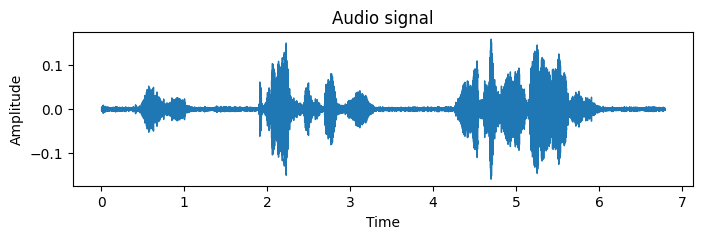

In [21]:
# Plot the audio signal just to have an idea of what it looks like
plt.figure(figsize=(8, 2))
lb.display.waveshow(audio, sr=sr)
plt.title('Audio signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
def create_folders(datasets, path = 'NormalisedAudio'):
    """
        This function creates folders for each dataset to add the normalised files
        df: Dataframe
        col: Column name
        path: Path to create the folders
    """
    # Get the locale types from the pd dataframe
    make_dir = path + '/' + datasets
    # create a directory for each type
    for dir in make_dir:
        os.makedirs(dir, exist_ok=True) 
        
        
def normalise_lpass(audio_file, output_file):
    """
        This function applies the normalisation and low pass filter to the audio file
        audio_file: Input audio file path
        output_file: Output audio file pathname
    """
    # Load the audio file with librosa
    audio, sr = lb.load(audio_file)

    # Normalise the audio using librosa
    normalised_audio = lb.util.normalize(audio)

    # Add low pass filter to improve the audio quality and remove some of the background noise
    a, b = signal.butter(20, 6000/(sr/2), btype='lowpass')
    rn_lpass = signal.lfilter(a,b,normalised_audio)

    # output the new file
    sf.write(output_file, rn_lpass, sr)
    print(f'Successfully normalised: {output_file}')


def audio_preprocessing(df, file_loc, dataset = 'dataset', output_loc='NormalisedAudio', filename='filename'):
    """
        This function iterates over the file list in the dataframe and calls the normalise_lpass function
        df: Dataframe
        file_loc: Column name for the file path
        dataset: Dataset column name
        output_loc: Path to create the folders
        filename: Filename column name
    """
    for idx, row in df.iterrows():
        input_file = row[file_loc]
        output_file = output_loc + '/' + row[dataset]  + '/' + row[filename] + '_NR.wav'

        # write to df a new column nr_filepath the output file
        df.loc[idx, 'nr_filepath'] = output_file
        normalise_lpass(input_file, output_file)

# Function to iterate over the file list in the dataframe and call the normalise_lpass function
audio_preprocessing(df, 'filepath')

In [27]:
df

,dataset,filename,filepath,transcription,emotion_label,clean_text,emotion_num,nr_filepath
0,IEMOCAP,Ses04M_script02_2_M040,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,I don't know. It seemed like a good spot to m...,happy,i do not know it seem like a good spot to me i...,6,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M040...
1,IEMOCAP,Ses04M_script02_2_M041,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"Shh. If we're very quiet, the fish might come.",happy,shh if we be very quiet the fish might come,6,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M041...
2,IEMOCAP,Ses04M_script02_2_F029,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,But this isn't anything like I thought anythin...,angry,but this be not anything like i think anything...,1,NormalisedAudio/IEMOCAP/Ses04M_script02_2_F029...
3,IEMOCAP,Ses04M_script02_2_M034,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"No, I know, me neither.",angry,no i know me neither,1,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M034...
4,IEMOCAP,Ses04M_script02_2_M020,Data/IEMOCAP/Session4/sentences/wav/Ses04M_scr...,"Wait a minute, I've got it.",neutral,wait a minute i have get it,0,NormalisedAudio/IEMOCAP/Ses04M_script02_2_M020...
...,...,...,...,...,...,...,...,...
21230,MELD,test_dia279_utt11,Data/MELD/test/mp4/test_dia279_utt11.mp4,"Yeah, I mean, come on Ross, no one will even n...",neutral,yeah i mean come on ross no one will even noti...,0,NormalisedAudio/MELD/test_dia279_utt11_NR.wav
21231,MELD,test_dia279_utt12,Data/MELD/test/mp4/test_dia279_utt12.mp4,They're not listening too me?,surprise,they be not listen too me,5,NormalisedAudio/MELD/test_dia279_utt12_NR.wav
21232,MELD,test_dia279_utt13,Data/MELD/test/mp4/test_dia279_utt13.mp4,Of course they're listening to you! Everybody ...,neutral,of course they be listen to you everybody list...,0,NormalisedAudio/MELD/test_dia279_utt13_NR.wav
21233,MELD,test_dia279_utt14,Data/MELD/test/mp4/test_dia279_utt14.mp4,Monica you really think I should try this phas...,neutral,monica you really think i should try this phas...,0,NormalisedAudio/MELD/test_dia279_utt14_NR.wav


In [20]:
# check that we have the same number of files in the dataframe and the folder
print(f'Number of files in the dataframe: {df.shape[0]}')
print(f'Number of files in the folder: {len(os.listdir("NormalisedAudio/MELD")) + len(os.listdir("NormalisedAudio/IEMOCAP"))}')

# check number of files from IEMOCAP dataframe and in the folder
print(f'Number of files from IEMOCAP: {len(os.listdir("NormalisedAudio/IEMOCAP"))}')
print(f'Number of files from IEMOCAP in the dataframe: {df[df.dataset == "IEMOCAP"].shape[0]}')

# check number of files from MELD dataframe and in the folder
print(f'Number of files from MELD: {len(os.listdir("NormalisedAudio/MELD"))}')
print(f'Number of files from MELD in the dataframe: {df[df.dataset == "MELD"].shape[0]}')

Number of files in the dataframe: 21235
Number of files in the folder: 21235
Number of files from IEMOCAP: 7529
Number of files from IEMOCAP in the dataframe: 7529
Number of files from MELD: 13706
Number of files from MELD in the dataframe: 13706


## Wav2Vec2 ASR

To examine the findings using ASR, Wav2Vec will be used, which employs neural networks and is capable of interpreting spoken language with exceptional precision. Wav2Vec is a free tool that allows quick and trustworthy transcriptions from audio files.

In [ ]:
import librosa as lr
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

# load the Wav2Vec2 model and tokenizer 
asr_tokenizer = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-robust-ft-libri-960h")
asr_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-robust-ft-libri-960h")

def transc_wav2vec2(audio_file):
    """
        This function transcribes the audio file to text using the Wav2Vec2 model
        audio_file: Path to the audio file
        return: Transcribed text
    """
    # load the audio data, set the sampling rate to 16kHz
    audio, sr = lr.load(audio_file, sr=16000)

    # tokenize the audio vector
    input_values = asr_tokenizer(audio, sampling_rate=sr, return_tensors="pt").input_values
    
    # retrieve logits
    logits = asr_model(input_values).logits

    # decode the text using the tokenizer 
    results = torch.argmax(logits, dim = -1)
    text = asr_tokenizer.batch_decode(results)[0].lower()
    return text

In [25]:
def wav2vec_transc(df, file_loc):
    """
        This function transcribes the audio files in the dataframe and writes the transcription to the dataframe
        df: Dataframe to transcribe
        file_loc: Column name of the file location
    """
    for idx, row in df.iterrows():
        input_file = row[file_loc]
        # check if the asr_transcription is null and transcribe the audio file
        if pd.isnull(row['asr_transcription']):
            # try to transcribe the audio file
            try:
                # transcribe the audio file
                transcription = transc_wav2vec2(input_file)
                
                # write the transcription to the dataframe
                df.at[idx, 'asr_transcription'] = transcription
                
            except: # if there is an error processing the file print the file name and continue
                print(f'Error processing file: {input_file}')
                continue
        else:
            print(f'File already processed: {input_file}, transcription: {row["asr_transcription"]}')
            continue

In [ ]:
# get the transcription of the audio files
wav2vec_transc(df, 'nr_filepath')

# Audio duration
To find the audio duration we will create a function to get the duration of each audio files and write it to the dataframe

In [17]:
def get_duration(df, file_loc):
    """
        Function to get the duration of the audio file and write it to the dataframe
        df: dataframe
        file_loc: column name where the file location is stored
    """
    # add an empty column where we will write the values to
    df['duration'] = np.nan

    for idx, row in df.iterrows():
        input_file = row[file_loc]
        # check if the asr_transcription is null and transcribe the audio file
        if pd.isnull(row['duration']):
            # try to transcribe the audio file
            try:
                # transcribe the audio file
                duration = lb.get_duration(path=input_file)
                
                # write the transcription to the dataframe
                df.at[idx, 'duration'] = duration
                
            except: # if there is an error processing the file print the file name and continue
                print(f'Error processing file: {input_file}')
                continue
        else:
            print(f'File already processed: {input_file}, duration: {row["duration"]}')
            continue

In [18]:
# get the duration of the audio files
get_duration(df, 'nr_filepath')

In [71]:
# get the max duration
max_duration = df['duration'].max()

# get the min duration
min_duration = df['duration'].min()

# get the mean duration
mean_duration = df['duration'].mean()

# print the max, min, and mean duration
print(f'Max duration: {max_duration}')
print(f'Min duration: {min_duration}')
print(f'Mean duration: {mean_duration}')

Max duration: 41.0453514739229
Min duration: 0.12104308390022676
Mean duration: 3.6952200462063027


In [34]:
# Checking the percentage of the dataset that is more than 8 seconds
print(f'Percentage of the dataset that is more than 8 seconds: {df[df.duration > 8].shape[0] / df.shape[0] * 100}%')

Percentage of the dataset that is more than 8 seconds: 7.530021191429244%


# Data Normalisation

During the next cells we will to apply a series of steps to normalise the data an ensure an uniform representation of the data. For this project it will be applied the following:

•	Lowercase sentences. \
•	Remove links, special characters, double or extra spaces, and punctuation. \
•	Standardised accents and retained alphanumeric characters. \
•	Expand contractions and abbreviations. \
•	Lemmatization 

In [19]:
# Apply lemmatization
wl = WordNetLemmatizer()

# https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
# Following the method from stackoverflow for get_wordnet_pos can get the pos tag for each word and then apply lemmatization
def get_wordnet_pos(tag):
    """
        This function maps the POS tag to the first character
        tag: POS tag
        return: WordNet POS tag
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence and return the lemmatized sentence
def lemmatizer(text):
    """
        This function lemmatizes the words in a sentence
        text: Sentence to lemmatize
        return: Lemmatized sentence
    """
    # Get position tags
    word_pos_tags = nltk.pos_tag(nltk.word_tokenize(text))
    # Map the position tag and lemmatize the word
    lem = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]

    # Join the list of words back into a sentence
    return " ".join(lem)

In [20]:
def normalise_text(text):
    """
        This function normalises the received sentence by applying multiple cleaning steps
        text: Sentence to normalise
        return: Normalised text
    """
    text = text.lower() # convert to lowercase
    text = re.sub(r"\r|\n|\t", "", text) # Remove new lines, tabs etc
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # remove urls
    text = contractions.fix(text) # expand contractions
    text = unidecode(text) # remove special accents
    text = re.sub(r"\s+"," ", text) # remove extra spaces
    text = lemmatizer(text) # lemmatize words

    return text

Apply the normalisation steps and add to a new column in the dataframe

In [ ]:
# Apply the clean_text function to the text column and create a new one named clean_text
df['clean_text'] = df['transcription'].swifter.apply(normalise_text)
df['asr_clean_text'] = df['asr_transcription'].swifter.apply(normalise_text)

In [24]:
df.head(10)

,dataset,filename,filepath,transcription,emotion_label,clean_text,emotion_num,nr_filepath,asr_transcription,asr_clean_text
0,IEMOCAP,Ses05M_script01_3_M036,Data/IEMOCAP/Session5/sentences/wav/Ses05M_scr...,"I felt what you said, ashamed somehow because ...",sad,"i felt what you say , ashamed somehow because ...",3,NormalisedAudio/IEMOCAP/Ses05M_script01_3_M036...,i theught what yo said ashamed somehow because...,i theught what yo say ashamed somehow because ...
1,IEMOCAP,Ses05M_script01_3_M037,Data/IEMOCAP/Session5/sentences/wav/Ses05M_scr...,It seemed to make suckers out of so many guys....,frustrated,it seem to make sucker out of so many guy . an...,4,NormalisedAudio/IEMOCAP/Ses05M_script01_3_M037...,it seemed to make suckers out of so many guies...,it seem to make sucker out of so many guy and ...
2,IEMOCAP,Ses05M_script01_3_M038,Data/IEMOCAP/Session5/sentences/wav/Ses05M_scr...,"you can take those things out of the war, but ...",frustrated,"you can take those thing out of the war , but ...",4,NormalisedAudio/IEMOCAP/Ses05M_script01_3_M038...,you can take those things out of the war but i...,you can take those thing out of the war but if...
3,IEMOCAP,Ses05M_script01_3_M039,Data/IEMOCAP/Session5/sentences/wav/Ses05M_scr...,And I guess that included you.,sad,and i guess that include you .,3,NormalisedAudio/IEMOCAP/Ses05M_script01_3_M039...,can i gess it included you,can i ge it include you
4,IEMOCAP,Ses05M_script01_3_M040,Data/IEMOCAP/Session5/sentences/wav/Ses05M_scr...,"I want you now, Annie.",sad,"i want you now , annie .",3,NormalisedAudio/IEMOCAP/Ses05M_script01_3_M040...,i want you now annie,i want you now annie
5,IEMOCAP,Ses05M_script01_3_M041,Data/IEMOCAP/Session5/sentences/wav/Ses05M_scr...,"Oh, Annie,",happy,"oh , annie ,",6,NormalisedAudio/IEMOCAP/Ses05M_script01_3_M041...,thanks,thanks
6,IEMOCAP,Ses05M_script01_3_M042,Data/IEMOCAP/Session5/sentences/wav/Ses05M_scr...,Annie I am going to make you a fortune.,happy,annie i be go to make you a fortune .,6,NormalisedAudio/IEMOCAP/Ses05M_script01_3_M042...,and i'm going to make you a fortune,and i be go to make you a fortune
7,IEMOCAP,Ses05M_script02_1_F000,Data/IEMOCAP/Session5/sentences/wav/Ses05M_scr...,Fine.,sad,fine .,3,NormalisedAudio/IEMOCAP/Ses05M_script02_1_F000...,bin,bin
8,IEMOCAP,Ses05M_script02_1_F001,Data/IEMOCAP/Session5/sentences/wav/Ses05M_scr...,What flashlight?,neutral,what flashlight ?,0,NormalisedAudio/IEMOCAP/Ses05M_script02_1_F001...,whet flashlight,whet flashlight
9,IEMOCAP,Ses05M_script02_1_F013,Data/IEMOCAP/Session5/sentences/wav/Ses05M_scr...,Pass what up? It's It's just little fish and ...,frustrated,pas what up ? it be it be just little fish and...,4,NormalisedAudio/IEMOCAP/Ses05M_script02_1_F013...,pat what up itit's just little fish and they s...,pat what up itit 's just little fish and they ...


### Sentence length analysis

Before we proceed with the data split and tokenization of the dataset, we must first examine the cleaned dataset to find out the length and frequency of the transcriptions. This is an important step as based on this information we can set the padding/truncation for the tokenizer function.

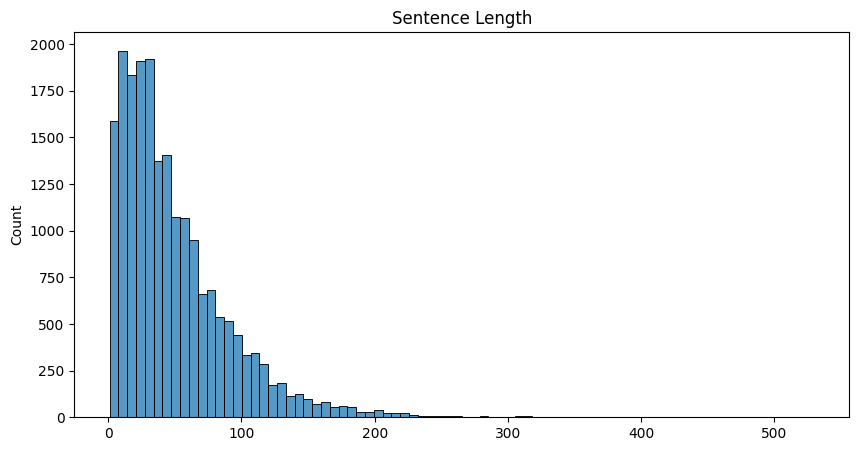

In [19]:
# Histogram of sentence length
plt.figure(figsize=(10, 5))
sns.histplot([len(x) for x in df.clean_text], bins=80)
plt.title('Sentence Length')
plt.show()

In [150]:
# Check the max length of a sentence
max_len = max([len(x) for x in df.clean_text])
print(f'Max sentence length: {max_len}')

# Variable that sums of sentences with length greater than 180
sum_val = sum([1 for x in df.clean_text if len(x) > 180])

# Number of sentences have length greater than 180
print(f'Number of sentences with length greater than 180: {sum_val}')

# Total number of tweets in the dataframe
print(f'Number of tweets in the dataframe: {df.shape[0]}')

# Percentage of sentences with length greater than 180
print(f'Percentage of sentences with length greater than 180: {sum_val*100/df.shape[0]:.4f}%')

Max sentence length: 509
Number of sentences with length greater than 180: 208
Number of tweets in the dataframe: 15164
Percentage of sentences with length greater than 180: 1.3717%


# Data split

The dataset for this project will be split into training, validation, and test sets. Following the ratio 80:10:10, respectively.

In [9]:
# create a function to split the dataset into train, validation and test sets
def split_data(df, stratify_col, train_test_size=0.2, val_test_size=0.5, random_state=42):
    """
        This function splits the dataset into train, validation and test sets
        df: Dataframe to split
        test_size: Size of the test set
        val_size: Size of the validation set
        random_state: Random state for reproducibility
        return: Train, validation and test sets
    """
    # Split the dataframe into train and test sets (80/20)
    train_df, test_df = train_test_split(df, test_size=train_test_size, random_state=random_state, stratify=df[stratify_col])

    # Split the train set into train and validation sets (50/50)
    val_df, test_df = train_test_split(test_df, test_size=val_test_size, random_state=random_state, stratify=test_df[stratify_col])

    return train_df, val_df, test_df

In [10]:
# Split the dataframe into train, validation and test sets
train_df, val_df, test_df = split_data(df, ['dataset','emotion_num'])

We can investigate the results by printing the shape of each dataset. Furthermore, we can also check if the stratify worked correctly as the dataset is imbalanced.

In [11]:
train_df.shape, val_df.shape, test_df.shape

((16125, 11), (2016, 11), (2016, 11))

In [12]:
# count the number of emotion labels in each set
print(f'{train_df.emotion_label.value_counts()}\n')
print(f'{val_df.emotion_label.value_counts()}\n')
print(f'{test_df.emotion_label.value_counts()}\n')

emotion_label
neutral       6394
angry         2129
joy           1799
sad           1656
frustrated    1478
surprise      1363
happy         1306
Name: count, dtype: int64

emotion_label
neutral       800
angry         267
joy           225
sad           207
frustrated    184
surprise      170
happy         163
Name: count, dtype: int64

emotion_label
neutral       799
angry         266
joy           225
sad           207
frustrated    185
surprise      170
happy         164
Name: count, dtype: int64



## Data Normalisation Merge Test

In [13]:
import unittest
import sys
from Test.Data.TestUNION import TestUNION

In [14]:
# Pass the variables to the test class
TestUNION.df = df
TestUNION.iemocap_df = iemocap_df
TestUNION.meld_df = meld_df
TestUNION.emotions = emotions
TestUNION.emotion_num = emotion_num
TestUNION.train_df = train_df
TestUNION.val_df = val_df
TestUNION.test_df = test_df

# Create an instance of the test class
test_class = TestUNION()

In [16]:
# Run the tests
suite = unittest.TestLoader().loadTestsFromTestCase(TestUNION)
unittest.TextTestRunner(verbosity=4,stream=sys.stderr).run(suite)

test_df_asr_clean_nline_tab (Test.Data.TestUNION.TestUNION.test_df_asr_clean_nline_tab) ... ok
test_df_asr_clean_text_urls (Test.Data.TestUNION.TestUNION.test_df_asr_clean_text_urls) ... ok
test_df_clean_text_double_spaces (Test.Data.TestUNION.TestUNION.test_df_clean_text_double_spaces) ... ok
test_df_clean_text_nline_tab (Test.Data.TestUNION.TestUNION.test_df_clean_text_nline_tab) ... ok
test_df_clean_text_urls (Test.Data.TestUNION.TestUNION.test_df_clean_text_urls) ... ok
test_df_columns (Test.Data.TestUNION.TestUNION.test_df_columns) ... ok
test_df_emotion_values (Test.Data.TestUNION.TestUNION.test_df_emotion_values) ... ok
test_df_emotions_length (Test.Data.TestUNION.TestUNION.test_df_emotions_length) ... ok
test_df_null (Test.Data.TestUNION.TestUNION.test_df_null) ... ok
test_df_rows (Test.Data.TestUNION.TestUNION.test_df_rows) ... ok
test_iemocap_rows (Test.Data.TestUNION.TestUNION.test_iemocap_rows) ... ok
test_meld_rows (Test.Data.TestUNION.TestUNION.test_meld_rows) ... ok
test

<unittest.runner.TextTestResult run=18 errors=0 failures=0>

### Export to CSV

In [ ]:
# exporting the final dataset and the train, validation and test sets
df.to_csv('Data/FinalDatasetASR.csv', index=False)
train_df.to_csv('Data/train_df_full.csv', index=False)
val_df.to_csv('Data/val_df_full.csv', index=False)
test_df.to_csv('Data/test_df_full.csv', index=False)